In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

pd.set_option('mode.chained_assignment', None)

# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity

In [48]:
def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2


def compute_jaccar_simlarity(matrix1, matrix2):

    def replace_with_one(x):
        return 1 if x >= 1 else x

    matrix1_1 = matrix1.applymap(replace_with_one)
    matrix2_1 = matrix2.applymap(replace_with_one)

    score = jaccard_score(matrix1_1.to_numpy(), matrix2_1.to_numpy(), average='weighted')
    weighted_score = weighted_jaccard_similarity(matrix1, matrix2)

    return score, weighted_score


In [49]:
import glob


main_path = '../networks/matrix/regions/'
paths = glob.glob(f'{main_path}*')

datasets ={}

for path in paths:

    mat = pd.read_csv(path, index_col=[0])
    name = path.split(main_path)[1].split('.csv')[0]

    if name in ['Japan', 'Korea', 'Ottoman Turkey', 'South East Asia', 'antiquity', 'europe', 'non_europe']:
        continue
    datasets[name] = mat

print(list(datasets.keys()))

['Persian world', 'Chinese world', 'Italy', 'Indian world', 'Slav world', 'Arabic world', 'France', 'Portugal', 'Spain', 'German world', 'Balkans', 'Nordic countries', 'Latin World', 'Central Europe', 'Greek World', 'Low countries', 'British Islands']


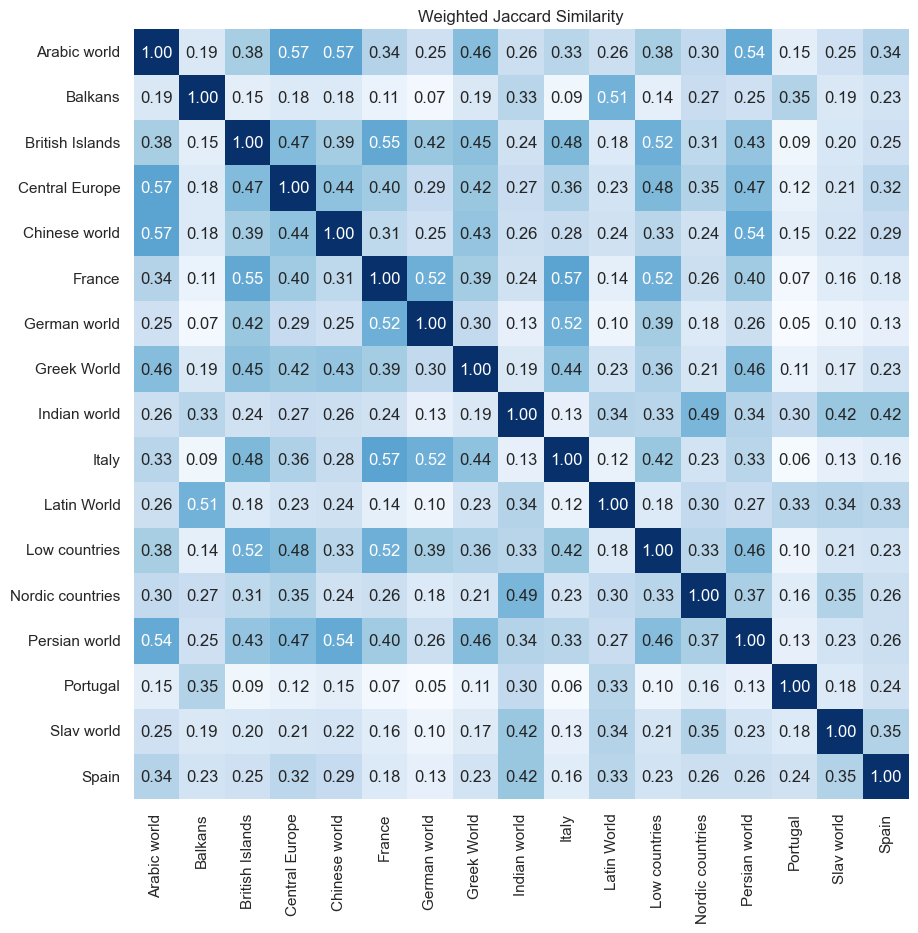

In [50]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Weighted Jaccard Similarity')

plt.show()
            

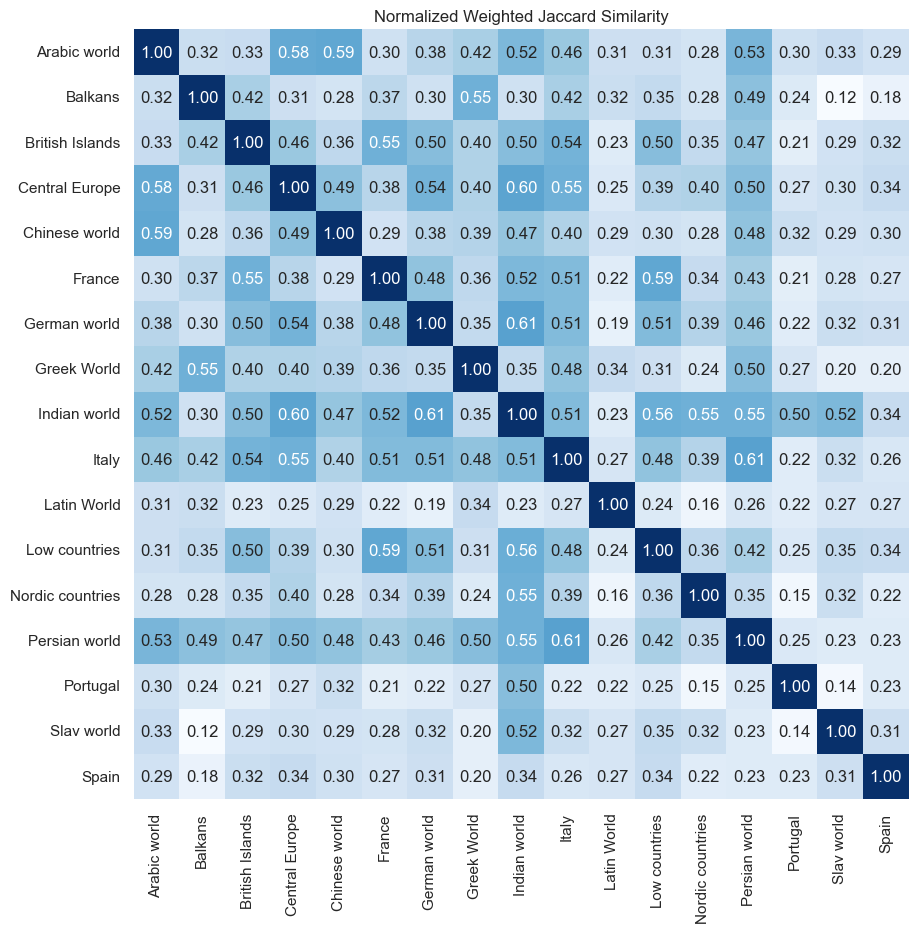

In [52]:
# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in datasets.items():
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset1['weight'] = (dataset1['weight'] - dataset1['weight'].min()) / (dataset1['weight'].max() - dataset1['weight'].min())
        dataset2 = dataset2[['source', 'target', 'weight']]
        dataset2['weight'] = (dataset2['weight'] - dataset2['weight'].min()) / (dataset2['weight'].max() - dataset2['weight'].min())

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        try:
            score = round(score, 2)
        except:
            score = score
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

# Print or analyze the ARI values as needed
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_df.astype(float), cmap='Blues', annot=True, fmt=".2f", cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Normalized Weighted Jaccard Similarity')
plt.show()

In [53]:
ari_df

,Dataset 1,Dataset 2,metric
0,Persian world,Persian world,1.0
1,Persian world,Chinese world,0.48
2,Persian world,Italy,0.61
3,Persian world,Indian world,0.55
4,Persian world,Slav world,0.23
...,...,...,...
284,British Islands,Latin World,0.23
285,British Islands,Central Europe,0.46
286,British Islands,Greek World,0.4
287,British Islands,Low countries,0.5


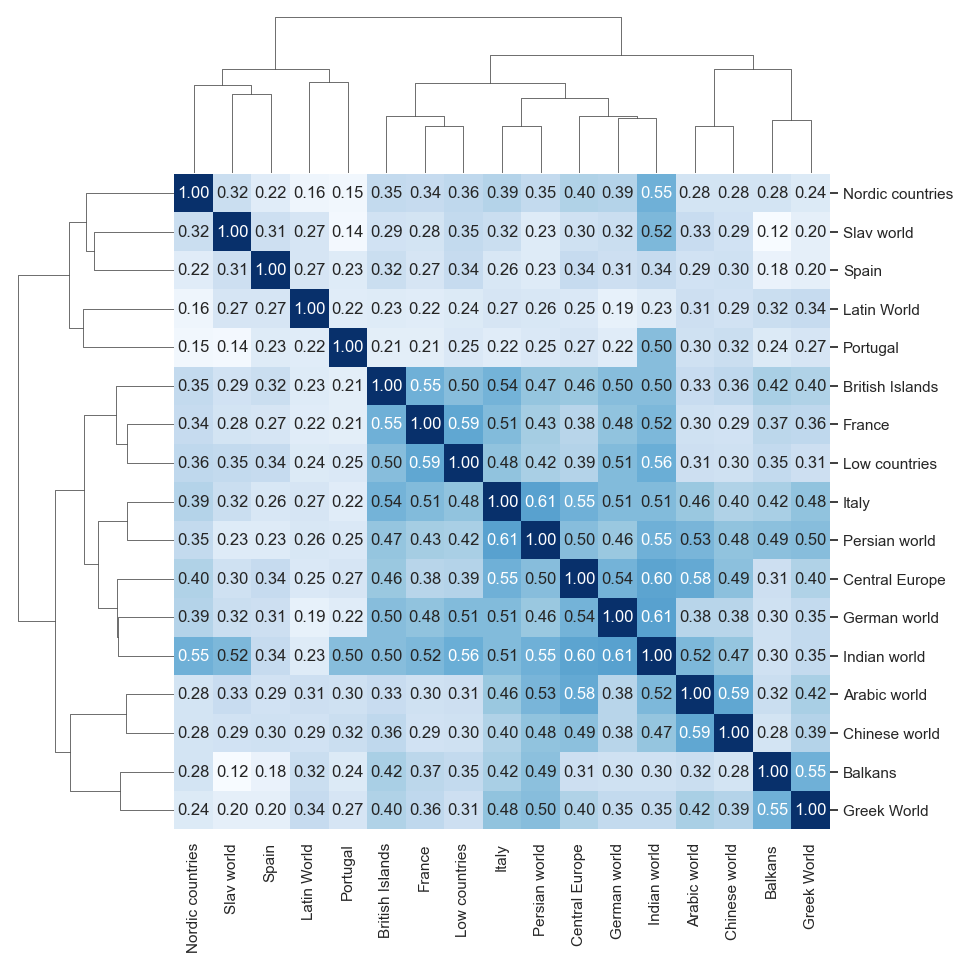

In [54]:
# Convert 'metric' column to numeric, replacing non-numeric values with NaN
ari_df['metric'] = pd.to_numeric(ari_df['metric'], errors='coerce')

# Create a hierarchical clustered heatmap using seaborn.clustermap
sns.set(font_scale=1.0)
clustered_heatmap = sns.clustermap(
    ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric'),
    cmap='Blues',
    annot=True,
    fmt=".2f",
    cbar_kws={"orientation": "horizontal", "label": None},  # Hide the color bar (legend)
    method='ward'
)
clustered_heatmap.ax_heatmap.set_ylabel('')  # Set y-label to an empty string
clustered_heatmap.ax_heatmap.set_xlabel('')  # Set y-label to an empty string
clustered_heatmap.cax.set_visible(False)

# Customize the appearance of the clustermap
plt.title('Hierarchical Clustering and Similarity')

# Show the plot
plt.show()